In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2


Using TensorFlow backend.


In [33]:
class PreProcessing():
    def __init__(self, list_data, target):
        '''create train and test data'''
        self.target = target
        self.train_sample = list_data[0].copy()
        self.test_sample = list_data[1].copy()
        self.test_sample = self.shuffle_data(self.test_sample)
        self.test_sample, self.val_sample = self._split_test_data()
        self.train_label = self._create_target(self.train_sample)
        self.test_label = self._create_target(self.test_sample)
        self.val_label = self._create_target(self.val_sample)
        self.process_data()
        
    def process_data(self):
        '''print summary and process data'''
        self._print_summary()
        self._training_sets_array()
        self._scale_data()
        
    def shuffle_data(self, dataset):
        '''shuffle dataset'''
        return shuffle(dataset).reset_index(drop=True)
    
    def _split_test_data(self):
        '''split data set and create validation set'''
        return train_test_split(self.test_sample, test_size=.2)
        
    def _create_target(self, dataset):
        '''create target for each dataset'''
        return np.array(dataset.pop(self.target))
        
    def _print_summary(self):
        '''print data set shape'''
        print("Training data shape:", self.train_sample.shape)
        print("Testing data shape:", self.test_sample.shape)
        print("Validation data shape:", self.val_sample.shape)
        print("train_label length:", self.train_label.shape[0])
        print("test_label length:", self.test_label.shape[0])
        print("val_label length:", self.val_label.shape[0])
        
    def _training_sets_array(self):
        '''convert data sets to array'''
        self.train_sample = np.array(self.train_sample)
        self.test_sample = np.array(self.test_sample)
        self.val_sample = np.array(self.val_sample)
        
    def _scale_data(self):
        '''apply standard scaler to datasets'''
        scaler = StandardScaler()
        self.train_sample = scaler.fit_transform(self.train_sample)
        self.test_sample = scaler.transform(self.test_sample)
        self.val_sample = scaler.transform(self.val_sample)


In [34]:
class CreateModel():
    def __init__(self):
        '''load data sets'''
        self.filepath_chkpt = './cp.ckpt/'
        self.train_sample = pp.train_sample
        self.train_label = pp.train_label
        self.test_sample = pp.test_sample
        self.test_label = pp.test_label
        self.val_sample = pp.val_sample
        self.val_label = pp.val_label
        self.cp_callback = self._define_checkpoint() 
    
    def _checkpoint_path(self):
        '''define checkpoint file path'''
        checkpoint_path = "./cp.ckpt/cp-{epoch:04d}.ckpt"
        return checkpoint_path
    
    def _define_checkpoint(self):
        '''create checkpoints'''
        checkpoint_path = self._checkpoint_path()
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_auc', 
                                                         verbose=0,
                                                         save_best_only=False, 
                                                         save_weights_only=True,
                                                         mode='max',
                                                         save_freq='epoch')
        return cp_callback
    
    def create_model(self, model, metrics, lr, loss):
        '''ingests and compile model'''
        model.compile(optimizer=keras.optimizers.Adam(lr=lr), 
                      loss=loss, metrics=metrics)
        return model
    
    def fit_model(self, model, epochs, fit_model=False):
        '''fit model and save weights'''
        if fit_model:
            model = self._save_weights(model)
            model.fit(self.train_sample, self.train_label, 
                      validation_data=(self.val_sample, self.val_label), 
                      batch_size=20, epochs=epochs, shuffle=True, verbose=2, 
                      workers=16, use_multiprocessing=True,
                      callbacks=[self.cp_callback])
            
        if ~fit_model:
            print("fit_model method is set to false.")
    
    def _save_weights(self, model):
        '''save weights'''
        checkpoint_path = self._checkpoint_path()
        model.save_weights(checkpoint_path.format(epoch=0))
        return model


In [35]:
class TuneThreshold():
    def __init__(self):
        '''tune threshold for each checkpoint'''
        self.current_thres = []
        self.top_score = []
        self.df_all_results = pd.DataFrame()
        self.best_chkpt = []
        self.best_threshold = []
        
    def tune_threshold(self, model):
        '''tune thresold'''
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        
        list_threshold = [.05, .1, .15, .2, .25, .3, .35, .4, .45, 
                          .5, .55, .6, .65, .7, .75, .8, .85, .9]
        self._tune_thres_methods(list_threshold, y_pred)
        list_tune_thres = self._fine_tune_thres()
        self._tune_thres_methods(list_tune_thres, y_pred)
        list_tune_thres = self._fine_tune_thres_2()
        self._tune_thres_methods(list_tune_thres, y_pred)        
        self._create_results_df()
        self._save_best_thres()
    
        
    def _tune_thres_methods(self, list_threshold, y_pred):
        '''caculate best threshold and save results'''
        list_auc_score = self._calc_thres_score(list_threshold, y_pred)        
        df_results = self._create_df_results(list_auc_score, list_threshold)
        self._calc_best_score(df_results)
        
    def _calc_thres_score(self, list_threshold, y_pred):
        '''calculate auc score for each threshold'''
        list_auc_score = []
        for thres in list_threshold:
            y_pred_class = binarize(y_pred, thres)
            fpr, tpr, thresholds = roc_curve(pp.test_label, 
                                             y_pred_class, 
                                             pos_label=1)
            auc_score = auc(fpr, tpr)
            list_auc_score.append(auc_score)
        return list_auc_score
    
    def _create_df_results(self, list_auc_score, list_threshold):
        '''create dataframe for best auc score and threshold'''
        col_thres = pd.Series(list_threshold, name='current_thres')
        col_auc = pd.Series(list_auc_score, name='auc_score')
        df_results = pd.concat([col_thres, col_auc], axis=1)
        return df_results
    
    def _calc_best_score(self, df_results):
        '''calculate the best score'''
        val_max_auc = df_results.auc_score.max()
        df_max_auc = df_results[df_results.auc_score == val_max_auc]
        df_max_auc_index = df_max_auc.index[0]
        self.current_thres = df_results.loc[df_max_auc_index, 'current_thres']
        self.top_score = val_max_auc 
    
    def _fine_tune_thres(self):
        '''fine tune threshold to nearest hundredth'''
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .01
            temp_val_pos = temp_val_pos + .01
            list_tune_thres.append(round(temp_val_neg, 2))
            list_tune_thres.append(round(temp_val_pos, 2))
        list_tune_thres.append(round(self.current_thres, 2))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _fine_tune_thres_2(self):
        '''fine tune threshold to thousandth place'''
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .001
            temp_val_pos = temp_val_pos + .001
            list_tune_thres.append(round(temp_val_neg, 3))
            list_tune_thres.append(round(temp_val_pos, 3))
        list_tune_thres.append(round(self.current_thres, 3))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _create_results_df(self):
        '''create final results dataframe'''
        col_chkpt = pd.Series(sc.chkpt_num, name='chkpt_epoch')
        col_thres = pd.Series(self.current_thres, name='best_threshold')
        col_auc = pd.Series(self.top_score, name='auc_score')
        df_temp = pd.concat([col_chkpt, col_thres, col_auc], axis=1)
        print(df_temp)
        self.df_all_results = pd.concat([self.df_all_results, df_temp], axis=0)
        
    def _save_best_thres(self):
        '''save highest scoring checkpoint and threshold'''
        dataset = self.df_all_results.copy()
        val_best_auc = dataset.auc_score.max()
        val_best_chkpt = dataset[dataset.auc_score==val_best_auc].chkpt_epoch
        val_best_thres = dataset[dataset.auc_score==val_best_auc].best_threshold
        self.best_chkpt = val_best_chkpt[0]
        self.best_threshold = val_best_thres[0]


In [36]:
class ScoreCheckpoints():
    def __init__(self):
        '''Loading and testing each checkpoint'''
        self.checkpoint_path = './cp.ckpt/'
        self.list_auc_score = []
        self.list_epoch = []
        self.chkpt_num = []
    
    def create_chkpt_list(self):
        '''create list of all saved checkpoints'''
        list_checkpoints = []
        for file in os.listdir(self.checkpoint_path):
            val_checkpoint = file[0:12]
            if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
                list_checkpoints.append(val_checkpoint)
        list_checkpoints.sort()
        return list_checkpoints
    
    def score_chkpts(self):
        '''score each checkpoint with highest scoring threshold'''
        list_checkpoints = self.create_chkpt_list()
        list_epoch = []
        for chkpt in list_checkpoints: # [67:68]: # setting 66:67 for fast testing
            filepath_chkpt = self.checkpoint_path + chkpt
            model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
            model.load_weights(filepath_chkpt)
            rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
            auc_score = self._calc_chkpt_score(rounded_predictions)
            self.chkpt_num = chkpt[3:7]
            tt.tune_threshold(model)
            self._plot_auc_scores()
        # printing final dataframe results
        print(tt.df_all_results)
        self._plot_auc_scores()
            
    def _calc_chkpt_score(self, rounded_predictions):
        '''calculate checkpoint score'''
        fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
        # cm = confusion_matrix(pp.test_label, rounded_predictions) #not needed for now 
        auc_score = auc(fpr, tpr)
        self.list_auc_score.append(auc_score)
        return auc_score
    
    def _plot_auc_scores(self):
        '''plot auc score for all checkpoints'''
        list_epoch = []
        for val in range(1, len(self.list_auc_score) + 1):
            list_epoch.append(val)
        plt.plot(list_epoch, self.list_auc_score)
        plt.title("Checkpoint Versus AUC Score")
        plt.ylabel("AUC Score")
        plt.xlabel("Checkpoint / Epoch")


In [55]:
class SaveModel():
    def __init__(self):
        '''load and predict from best model'''
        self.chkpt_file_path = self._create_file_path()
        self.saved_model_file_path = mod.filepath_chkpt + 'saved_model/'
    
    def _create_file_path(self):
        '''create model file path'''
        chkpt_file_path = mod.filepath_chkpt + 'cp-' + tt.best_chkpt + '.ckpt'
        return chkpt_file_path
    
    def save_best_model(self):
        '''save best performing model in tf format'''
        model = self._load_model_weights()
        save_model_file_path = mod.filepath_chkpt + 'saved_model/' 
        tf.saved_model.save(model, self.saved_model_file_path)
    
    def _load_model_weights(self):
        '''load model weights for best model'''
        model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
        model.load_weights(self.chkpt_file_path)
        return model
        
    def load_saved_model(self, summary=False):
        '''loading best model'''
        model = tf.keras.models.load_model(self.saved_model_file_path)
        if summary:
            print('\n')
            print(model.summary())
            print('\n')
        return model

    def predict_binarize(self, model, test_data):
        '''create prediction with best model and threshold'''
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        y_pred_class = binarize(y_pred, tt.best_threshold)
        fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
        auc_score = auc(fpr, tpr)
        print('\nauc for best model and best threshold:', auc_score)
        return y_pred_class


### Load Data

In [38]:
filepath_data = '/Users/krahman/work/tutorials/tensorflow_classification/data/'

df_raw = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1) #del once finished testing

train_sample = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1)
train_label = pd.read_csv(filepath_data + 'mod_y_train.csv').drop('Unnamed: 0', axis=1)
train_sample = pd.concat([train_sample, train_label], axis=1)
test_sample = pd.read_csv(filepath_data + 'mod_x_test.csv').drop('Unnamed: 0', axis=1)
test_label = pd.read_csv(filepath_data + 'mod_y_test.csv').drop('index', axis=1)
test_sample = pd.concat([test_sample, test_label], axis=1)

target = '0'

list_data = [train_sample, test_sample]


### Instantiate PreProcessing Class

In [39]:
pp = PreProcessing(list_data, target)

Training data shape: (190000, 233)
Testing data shape: (47243, 233)
Validation data shape: (11811, 233)
train_label length: 190000
test_label length: 47243
val_label length: 11811


### Instantiate CreateModel Class

In [56]:
mod = CreateModel()

### Defining Neural Network Layers

In [57]:
DF_TRAIN = pp.train_sample

neg, pos = np.bincount(train_sample[target])
initial_bias = np.log([pos/neg])
OUTPUT_BIAS = tf.keras.initializers.Constant(initial_bias)
LOSS = keras.losses.BinaryCrossentropy()
LR = .0001
METRICS = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

MODEL_SEQ = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])

# MODEL_SEQ = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])


### Creating Model

In [59]:
model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)

### Fitting Model

In [60]:
mod.fit_model(model, epochs=3, fit_model=False)

fit_model method is set to false.


### Instantiate TuneThreshold Class

In [61]:
tt = TuneThreshold()

### Instantiate ScoreCheckpoints Class

In [62]:
sc = ScoreCheckpoints()

#### Score Checkpoints

  chkpt_epoch  best_threshold  auc_score
0        0000           0.331   0.500725
  chkpt_epoch  best_threshold  auc_score
0        0001            0.37    0.83809
  chkpt_epoch  best_threshold  auc_score
0        0002           0.323   0.846459
  chkpt_epoch  best_threshold  auc_score
0        0003           0.362   0.845002
  chkpt_epoch  best_threshold  auc_score
0        0004           0.219   0.848718
  chkpt_epoch  best_threshold  auc_score
0        0005            0.14   0.853682
  chkpt_epoch  best_threshold  auc_score
0        0006           0.217   0.857132
  chkpt_epoch  best_threshold  auc_score
0        0007           0.145   0.846372
  chkpt_epoch  best_threshold  auc_score
0        0008           0.124   0.864912
  chkpt_epoch  best_threshold  auc_score
0        0009           0.291     0.8598


  chkpt_epoch  best_threshold  auc_score
0        0010           0.241   0.861331
  chkpt_epoch  best_threshold  auc_score
0        0011            0.23   0.858695
  chkpt_epoch  best_threshold  auc_score
0        0012           0.198   0.861911
  chkpt_epoch  best_threshold  auc_score
0        0013           0.203   0.860028
  chkpt_epoch  best_threshold  auc_score
0        0014            0.18   0.864034
  chkpt_epoch  best_threshold  auc_score
0        0015           0.169   0.864681
  chkpt_epoch  best_threshold  auc_score
0        0016           0.101   0.853946
  chkpt_epoch  best_threshold  auc_score
0        0017            0.28     0.8649
  chkpt_epoch  best_threshold  auc_score
0        0018           0.132   0.864562


  chkpt_epoch  best_threshold  auc_score
0        0019           0.113   0.863189
  chkpt_epoch  best_threshold  auc_score
0        0020            0.15   0.861608
  chkpt_epoch  best_threshold  auc_score
0        0021           0.205   0.870776
  chkpt_epoch  best_threshold  auc_score
0        0022           0.259   0.866266
  chkpt_epoch  best_threshold  auc_score
0        0023            0.19     0.8624
  chkpt_epoch  best_threshold  auc_score
0        0024           0.197    0.86798
  chkpt_epoch  best_threshold  auc_score
0        0025           0.102     0.8611
  chkpt_epoch  best_threshold  auc_score
0        0026           0.313    0.85959
  chkpt_epoch  best_threshold  auc_score
0        0027           0.212   0.861867


  chkpt_epoch  best_threshold  auc_score
0        0028           0.151    0.86099
  chkpt_epoch  best_threshold  auc_score
0        0029           0.112   0.863798
  chkpt_epoch  best_threshold  auc_score
0        0030           0.155   0.869363
  chkpt_epoch  best_threshold  auc_score
0        0031            0.22   0.864386
  chkpt_epoch  best_threshold  auc_score
0        0032           0.199   0.870214
  chkpt_epoch  best_threshold  auc_score
0        0033           0.123   0.864888
  chkpt_epoch  best_threshold  auc_score
0        0034           0.241   0.865441
  chkpt_epoch  best_threshold  auc_score
0        0035           0.133   0.859364
  chkpt_epoch  best_threshold  auc_score
0        0036           0.141   0.870891


  chkpt_epoch  best_threshold  auc_score
0        0037           0.125   0.859752
  chkpt_epoch  best_threshold  auc_score
0        0038           0.074   0.861769
  chkpt_epoch  best_threshold  auc_score
0        0039           0.173   0.859731
  chkpt_epoch  best_threshold  auc_score
0        0040           0.295   0.866455
  chkpt_epoch  best_threshold  auc_score
0        0041           0.194   0.869215
  chkpt_epoch  best_threshold  auc_score
0        0042           0.191   0.864256
  chkpt_epoch  best_threshold  auc_score
0        0043           0.296   0.863461
  chkpt_epoch  best_threshold  auc_score
0        0044           0.141   0.863442
  chkpt_epoch  best_threshold  auc_score
0        0045           0.286   0.866332


  chkpt_epoch  best_threshold  auc_score
0        0046           0.282   0.872976
  chkpt_epoch  best_threshold  auc_score
0        0047           0.332   0.866921
  chkpt_epoch  best_threshold  auc_score
0        0048           0.371   0.860971
  chkpt_epoch  best_threshold  auc_score
0        0049           0.128   0.865597
  chkpt_epoch  best_threshold  auc_score
0        0050           0.365   0.860979
  chkpt_epoch  best_threshold  auc_score
0        0051           0.085   0.862626
  chkpt_epoch  best_threshold  auc_score
0        0052           0.101   0.863491
  chkpt_epoch  best_threshold  auc_score
0        0053           0.271   0.867475
  chkpt_epoch  best_threshold  auc_score
0        0054           0.231   0.869162


  chkpt_epoch  best_threshold  auc_score
0        0055            0.19   0.870481
  chkpt_epoch  best_threshold  auc_score
0        0056           0.099    0.85797
  chkpt_epoch  best_threshold  auc_score
0        0057           0.144   0.866588
  chkpt_epoch  best_threshold  auc_score
0        0058           0.288   0.865538
  chkpt_epoch  best_threshold  auc_score
0        0059           0.297   0.867295
  chkpt_epoch  best_threshold  auc_score
0        0060            0.14   0.866887
  chkpt_epoch  best_threshold  auc_score
0        0061           0.089   0.862041
  chkpt_epoch  best_threshold  auc_score
0        0062           0.109   0.866778
  chkpt_epoch  best_threshold  auc_score
0        0063            0.16   0.862342


  chkpt_epoch  best_threshold  auc_score
0        0064           0.343   0.865347
  chkpt_epoch  best_threshold  auc_score
0        0065           0.092   0.861334
  chkpt_epoch  best_threshold  auc_score
0        0066           0.208   0.859165
  chkpt_epoch  best_threshold  auc_score
0        0067           0.238   0.864657
  chkpt_epoch  best_threshold  auc_score
0        0068           0.212   0.863524
  chkpt_epoch  best_threshold  auc_score
0        0069           0.269   0.859173
  chkpt_epoch  best_threshold  auc_score
0        0070           0.185   0.859646
  chkpt_epoch  best_threshold  auc_score
0        0071           0.207   0.865992
  chkpt_epoch  best_threshold  auc_score
0        0072           0.093   0.866939


  chkpt_epoch  best_threshold  auc_score
0        0073           0.221   0.866001
  chkpt_epoch  best_threshold  auc_score
0        0074           0.214    0.86407
  chkpt_epoch  best_threshold  auc_score
0        0075           0.278   0.868042
  chkpt_epoch  best_threshold  auc_score
0        0076           0.119   0.860906
  chkpt_epoch  best_threshold  auc_score
0        0077            0.12    0.86396
  chkpt_epoch  best_threshold  auc_score
0        0078           0.154   0.858878
  chkpt_epoch  best_threshold  auc_score
0        0079             0.1   0.864723
  chkpt_epoch  best_threshold  auc_score
0        0080           0.085   0.865526
  chkpt_epoch  best_threshold  auc_score
0        0081           0.132   0.856322


  chkpt_epoch  best_threshold  auc_score
0        0082           0.131   0.862487
  chkpt_epoch  best_threshold  auc_score
0        0083           0.149   0.859702
  chkpt_epoch  best_threshold  auc_score
0        0084           0.169   0.865425
  chkpt_epoch  best_threshold  auc_score
0        0085           0.175   0.869558
  chkpt_epoch  best_threshold  auc_score
0        0086           0.047   0.865252
  chkpt_epoch  best_threshold  auc_score
0        0087           0.173   0.867218
  chkpt_epoch  best_threshold  auc_score
0        0088            0.17   0.860548
  chkpt_epoch  best_threshold  auc_score
0        0089            0.13    0.86174
  chkpt_epoch  best_threshold  auc_score
0        0090           0.252    0.86798


  chkpt_epoch  best_threshold  auc_score
0        0091           0.155   0.863562
  chkpt_epoch  best_threshold  auc_score
0        0092           0.231   0.859402
  chkpt_epoch  best_threshold  auc_score
0        0093           0.127   0.867366
  chkpt_epoch  best_threshold  auc_score
0        0094           0.221   0.868696
  chkpt_epoch  best_threshold  auc_score
0        0095           0.299   0.870764
  chkpt_epoch  best_threshold  auc_score
0        0096           0.075    0.86251
  chkpt_epoch  best_threshold  auc_score
0        0097           0.355   0.862949
  chkpt_epoch  best_threshold  auc_score
0        0098           0.112   0.860145
  chkpt_epoch  best_threshold  auc_score
0        0099           0.113   0.854147


  chkpt_epoch  best_threshold  auc_score
0        0100           0.204   0.855998
   chkpt_epoch  best_threshold  auc_score
0         0000           0.331   0.500725
0         0001           0.370   0.838090
0         0002           0.323   0.846459
0         0003           0.362   0.845002
0         0004           0.219   0.848718
..         ...             ...        ...
0         0096           0.075   0.862510
0         0097           0.355   0.862949
0         0098           0.112   0.860145
0         0099           0.113   0.854147
0         0100           0.204   0.855998

[101 rows x 3 columns]


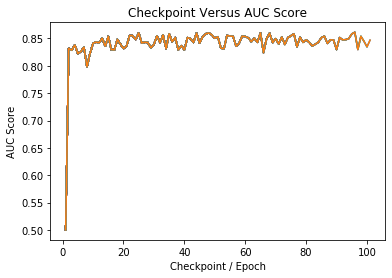

In [63]:
list_checkpoints = sc.create_chkpt_list()
sc.score_chkpts()

#### Save Best Performing Checkpoint / Model

In [64]:
sm = SaveModel()
sm.save_best_model()

INFO:tensorflow:Assets written to: ./cp.ckpt/saved_model/assets


#### Load Best Saved Model

In [65]:
model_1 = sm.load_saved_model(summary=True)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               59904     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_37 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_39 (Dense)             (None, 256)            

#### Create Prediction Using Best Model

In [66]:
y_pred = sm.predict_binarize(model_1, pp.test_sample)
y_pred


auc for best model and best threshold: 0.8729763023808472


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)